In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            ConfusionMatrixDisplay)

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Load dataset
df = pd.read_csv('/content/Iris.csv')

# Data Exploration
print("Dataset Information:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nClass Distribution:")
print(df['Species'].value_counts())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Summary Statistics:
               Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count  150.000000     150.000000    150.000000     150.000000    150.000000
mean    75.500000       5.843333      3.054000       3.758667      1.198667
std     43.445368       0.828066      0.433594       1.764420      0.763161
min      1.000000       4.300000      2.000000       1.000000      0.100000
25%     38.250000       5.100000      2.800000       1.

<Figure size 1200x800 with 0 Axes>

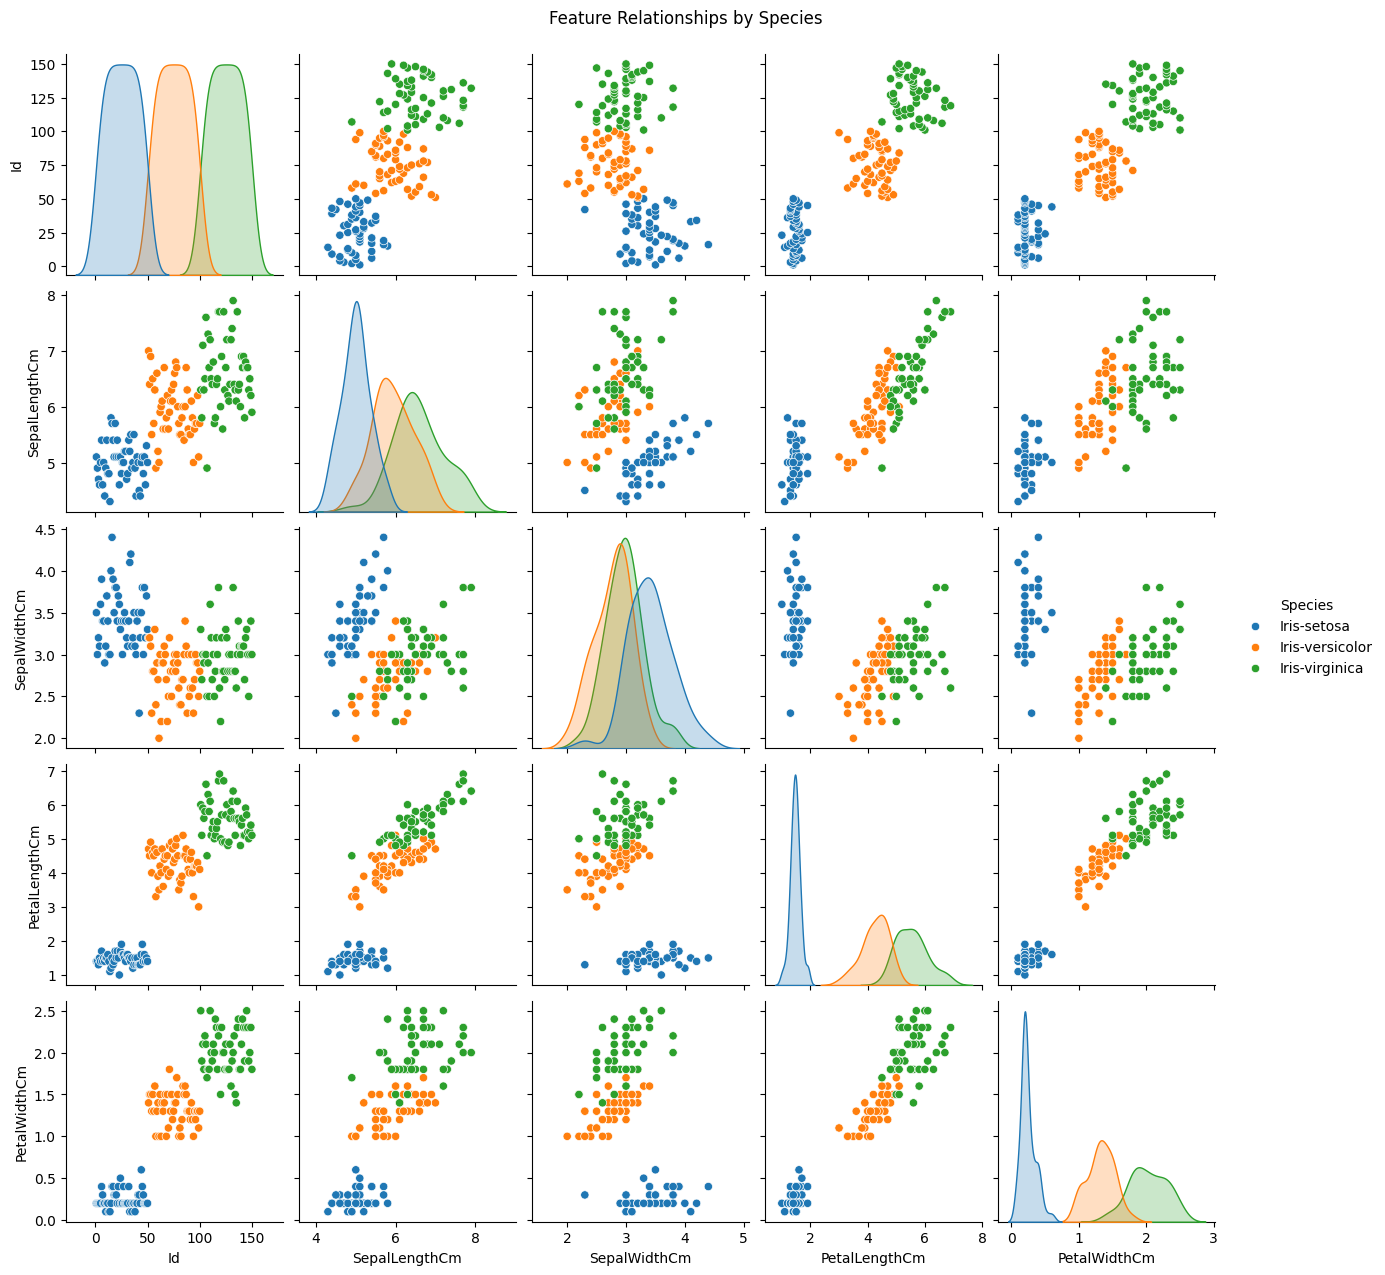

In [19]:
# Data Visualization
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='Species')
plt.suptitle('Feature Relationships by Species', y=1.02)
plt.show()

In [20]:
# Data Preparation
df = df.drop(columns=['Id'])
X = df.drop('Species', axis=1)
y = df['Species']

# Encode labels
y_encoded = y.astype('category').cat.codes
class_names = y.astype('category').cat.categories

In [21]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Baseline Models Evaluation
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

baseline_results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    baseline_results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4)
    })

print("\nBaseline Model Performance:")
display(pd.DataFrame(baseline_results))

# Hyperparameter Tuning
print("\n=== Hyperparameter Tuning ===")


Baseline Model Performance:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.9333,0.9333,0.9333,0.9333
1,Random Forest,0.9000,0.9024,0.9000,0.8997
2,SVM,0.9667,0.9697,0.9667,0.9666



=== Hyperparameter Tuning ===


In [23]:
# Logistic Regression Tuning
param_grid_lr = {
    'C': np.logspace(-3, 3, 7),
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'penalty': ['l2']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                      param_grid_lr,
                      scoring='f1_macro',
                      cv=5,
                      n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("\nLogistic Regression:")
print("Best Parameters:", grid_lr.best_params_)
print("Best CV F1 Score:", round(grid_lr.best_score_, 4))



Logistic Regression:
Best Parameters: {'C': np.float64(10.0), 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 Score: 0.9663


In [24]:
# Random Forest Tuning
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rand_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                           param_distributions=param_dist_rf,
                           n_iter=20,
                           scoring='f1_macro',
                           cv=5,
                           random_state=42,
                           n_jobs=-1)
rand_rf.fit(X_train_scaled, y_train)

print("\nRandom Forest:")
print("Best Parameters:", rand_rf.best_params_)
print("Best CV F1 Score:", round(rand_rf.best_score_, 4))


Random Forest:
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Best CV F1 Score: 0.9582


In [25]:
# SVM Tuning
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(random_state=42),
                       param_grid_svm,
                       scoring='f1_macro',
                       cv=5,
                       n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)

print("\nSupport Vector Machine:")
print("Best Parameters:", grid_svm.best_params_)
print("Best CV F1 Score:", round(grid_svm.best_score_, 4))


Support Vector Machine:
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV F1 Score: 0.9749


In [26]:
# Final Model Evaluation
final_models = {
    'Logistic Regression (Tuned)': grid_lr.best_estimator_,
    'Random Forest (Tuned)': rand_rf.best_estimator_,
    'SVM (Tuned)': grid_svm.best_estimator_
}

final_results = []

for name, model in final_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    final_results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4)
    })

print("\nFinal Model Performance:")
final_df = pd.DataFrame(final_results)
display(final_df)


Final Model Performance:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Tuned),1.0000,1.0000,1.0000,1.0000
1,Random Forest (Tuned),0.9667,0.9697,0.9667,0.9666
2,SVM (Tuned),1.0000,1.0000,1.0000,1.0000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


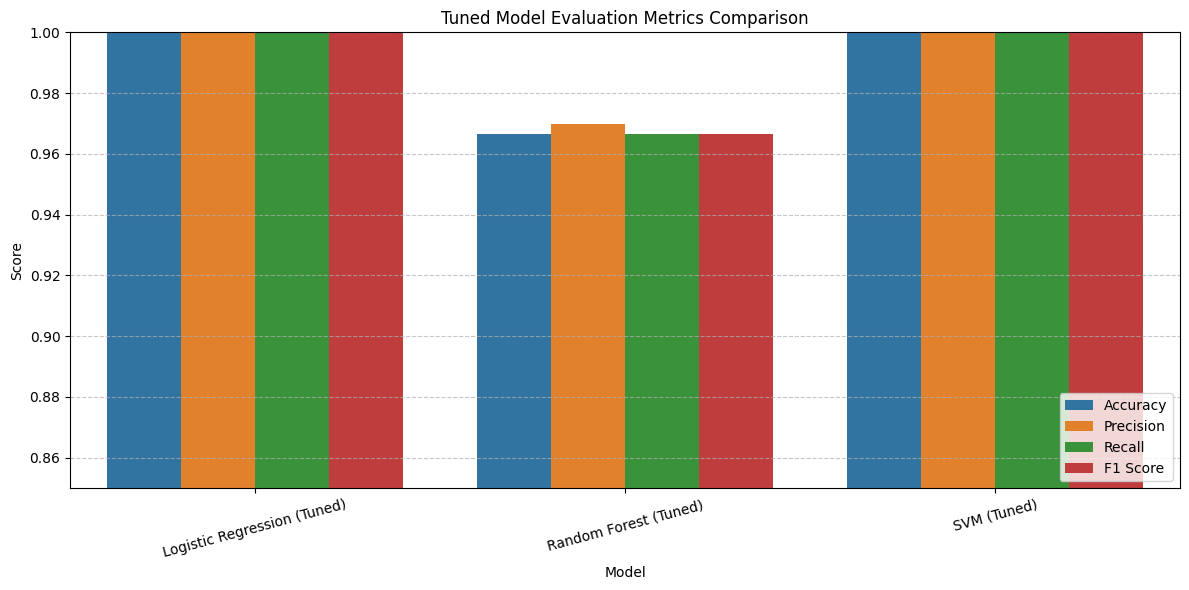

In [27]:
# Visualization of Results
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
final_df_melted = final_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=final_df_melted)
plt.title("Tuned Model Evaluation Metrics Comparison")
plt.ylim(0.85, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

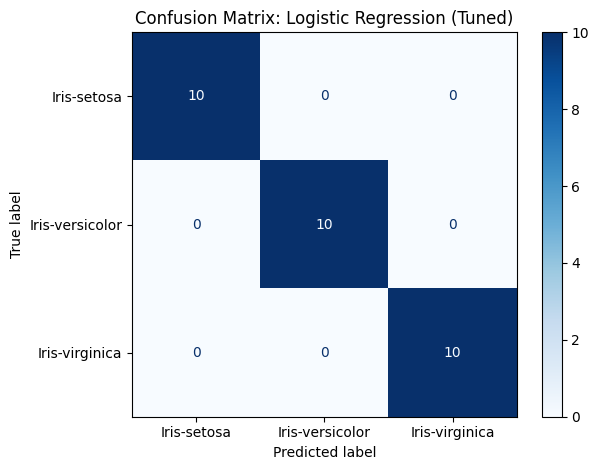

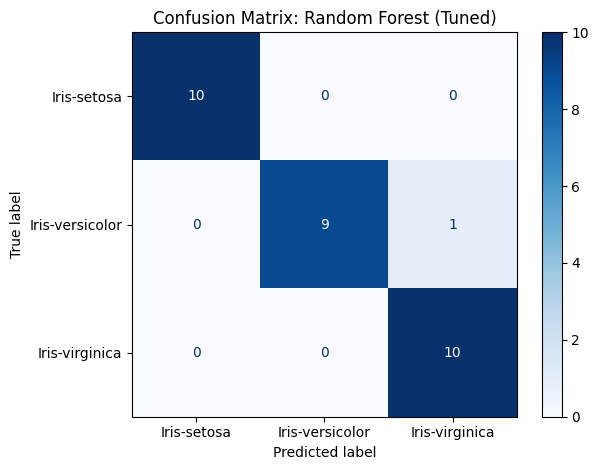

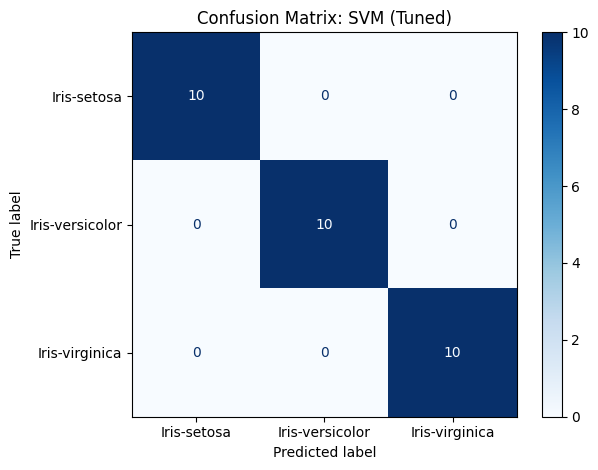

In [28]:
# Confusion Matrices
for name, model in final_models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()

In [29]:
# Classification Reports
for name, model in final_models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report for Logistic Regression (Tuned):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Classification Report for Random Forest (Tuned):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30


Classification Report for SVM (Tuned):
                 precision    recall  f1-score   s

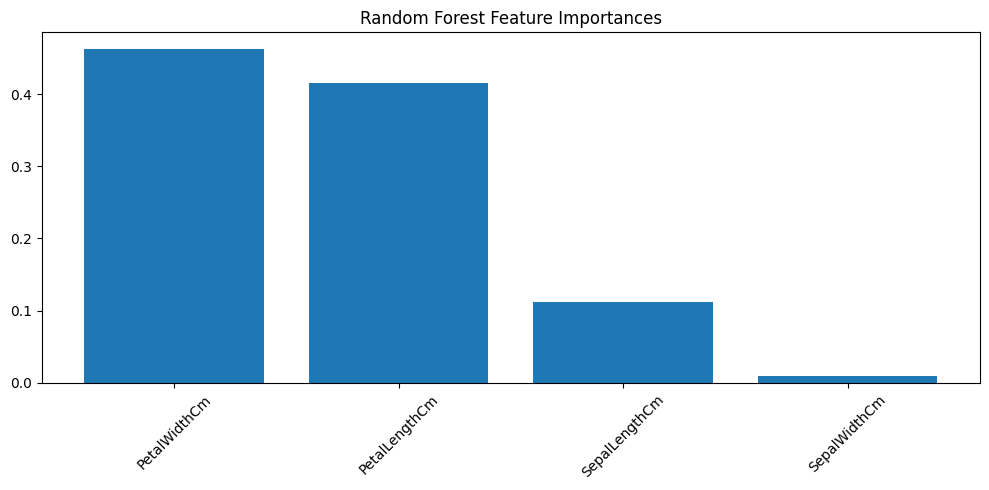

In [30]:
# Feature Importance for Random Forest
if hasattr(rand_rf.best_estimator_, 'feature_importances_'):
    plt.figure(figsize=(10, 5))
    importances = rand_rf.best_estimator_.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.title("Random Forest Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
    plt.tight_layout()
    plt.show()

In [31]:
# Best Model Selection
best_model_name = final_df.loc[final_df['F1 Score'].idxmax(), 'Model']
best_model = final_models[best_model_name]
print(f"\nBest Performing Model: {best_model_name}")


Best Performing Model: Logistic Regression (Tuned)


In [32]:
import joblib
joblib.dump(best_model, 'best_iris_classifier.pkl')
print("Best model saved as 'best_iris_classifier.pkl'")

Best model saved as 'best_iris_classifier.pkl'
